In [43]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer


In [44]:
# df = pd.read_csv(r'../../resources/dataset_sentimientos_robusto.csv')
# df.head()

In [45]:
splits = {'train': 'data/train-00000-of-00001-b9bddb52d8219a12.parquet', 'test': 'data/test-00000-of-00001-d161e0d7d20a9b0a.parquet'}
df_train = pd.read_parquet("hf://datasets/vg055/analisis-sentimientos-textos-turisitcos-mx-polaridadV3-DA/" + splits["train"])

In [46]:
df_train.head()

,text,label
0,La mejor relación calidad-precio Deliciosa com...,5
1,Nos sentimos especiales El 28 de enero era nue...,5
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",3
3,Muchas piezas de oro es simplemente increíble ...,5
4,Se cayeron 2 estrellas Cuando vi la calificaci...,3


In [47]:
splits = {'train': 'data/train-00000-of-00001-b9bddb52d8219a12.parquet', 'test': 'data/test-00000-of-00001-d161e0d7d20a9b0a.parquet'}
df_test = pd.read_parquet("hf://datasets/vg055/analisis-sentimientos-textos-turisitcos-mx-polaridadV3-DA/" + splits["test"])

In [48]:
df_test.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


In [49]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,text,label
0,La mejor relación calidad-precio Deliciosa com...,5
1,Nos sentimos especiales El 28 de enero era nue...,5
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",3
3,Muchas piezas de oro es simplemente increíble ...,5
4,Se cayeron 2 estrellas Cuando vi la calificaci...,3


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299820 entries, 0 to 299819
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    299820 non-null  object
 1   label   299820 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [51]:
df['sentimiento'] = df['label'].map(
    {5: 'Positivo',
     4: 'Positivo',
     3: 'Neutro', 
     2: 'Negativo',
     1: 'Negativo'
    })

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299820 entries, 0 to 299819
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         299820 non-null  object
 1   label        299820 non-null  int64 
 2   sentimiento  299820 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.9+ MB


In [53]:
df = df[['text', 'sentimiento']]
df.head()

,text,sentimiento
0,La mejor relación calidad-precio Deliciosa com...,Positivo
1,Nos sentimos especiales El 28 de enero era nue...,Positivo
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",Neutro
3,Muchas piezas de oro es simplemente increíble ...,Positivo
4,Se cayeron 2 estrellas Cuando vi la calificaci...,Neutro


In [54]:
distribucion_sentimentos = round(df['sentimiento'].value_counts(normalize = True)*100,2)
print(distribucion_sentimentos)

sentimiento
Positivo    72.48
Neutro      13.80
Negativo    13.71
Name: proportion, dtype: float64


In [56]:
corpus_entrenamiento, corpus_prueba, y_entrenamiento, y_prueba = train_test_split(
    df['text'],
    df['sentimiento'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['sentimiento'])

In [58]:
def print_distribution(name, series):
    series = pd.Series(series)
    dist = round(series.value_counts(normalize=True), 2)
    print(f"{name} Distribution:\n{dist}\n")

# Maintains the original Odyssey/Iliad ratio
print_distribution("Distribución Entrenamiento", y_entrenamiento)
print_distribution("Distribución Prueba", y_prueba)

Distribución Entrenamiento Distribution:
sentimiento
Positivo    0.72
Neutro      0.14
Negativo    0.14
Name: proportion, dtype: float64

Distribución Prueba Distribution:
sentimiento
Positivo    0.72
Neutro      0.14
Negativo    0.14
Name: proportion, dtype: float64



In [59]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Eliminar stopwords y lematizar
stopword_list = set(stopwords.words('spanish'))

def procesar_texto_español(texto):
    """
    Función para limpiar y preprocesar texto en español.
    """
    # Manejo de valores nulos
    if not isinstance(texto, str):
        return ""
    
    # Eliminar HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar emojis
    texto = re.sub(r"[^\w\sáéíóúñü]",
        "",
        texto)
    
    # Tokenizar
    tokens = word_tokenize(texto, language='spanish')
    
    # Eliminar stopwords y lematizar
    tokens_limpios = [token for token in tokens if token not in stopword_list and len(token) > 2]
    return ' '.join(tokens_limpios) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
corpus_entrenamiento_normalizado = [procesar_texto_español(text) for text in corpus_entrenamiento]
corpus_prueba_normalizado = [procesar_texto_español(text) for text in corpus_prueba]

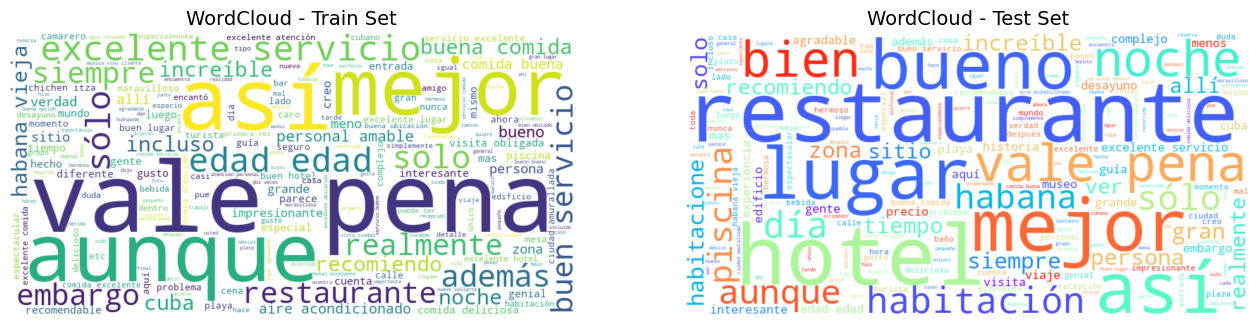

In [61]:
texto_entrenamiento = " ".join(corpus_entrenamiento_normalizado)
texto_prueba = " ".join(corpus_prueba_normalizado)

wc_train = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_entrenamiento)
wc_test = WordCloud(width=800, height=400, background_color="white", colormap="rainbow").generate(texto_prueba)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_train, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Train Set", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wc_test, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Test Set", fontsize=14)

plt.show()

In [62]:
vectorizer = TfidfVectorizer(
    norm= 'l2',
    smooth_idf= True,
    use_idf= True,
    ngram_range= (1,2), 
    max_df= 0.90,
    min_df= 2)

tfidf_matrix_entrenamiento = vectorizer.fit_transform(corpus_entrenamiento_normalizado)
tfidf_matrix_prueba = vectorizer.transform(corpus_prueba_normalizado)


In [63]:
np.unique(y_prueba)

array(['Negativo', 'Neutro', 'Positivo'], dtype=object)

In [73]:
def evaluacion_modelos(y_real, y_pred):
    
    labels = ['Negativo', 'Neutro', 'Positivo']

    print(f'Accuracy: {round(accuracy_score(y_real, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'F1-Score: {round(f1_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'Recall: {round(recall_score(y_real, y_pred, average= "weighted"),2)}')
    
    matriz_confusion_modelo = confusion_matrix(y_real, y_pred, normalize= "true")
    visualizacion_matriz_confusion = ConfusionMatrixDisplay(matriz_confusion_modelo, display_labels= labels)
    visualizacion_matriz_confusion.plot();
    print(classification_report(y_real, y_pred, target_names= labels))


In [65]:
tfidf_matrix_entrenamiento.shape, tfidf_matrix_prueba.shape

((239856, 884422), (59964, 884422))

In [66]:
modelo_lr = LogisticRegression(
    max_iter= 1000,
    random_state= 42,
    class_weight= 'balanced')

modelo_lr.fit(tfidf_matrix_entrenamiento, y_entrenamiento)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [67]:
y_pred_lr = modelo_lr.predict(tfidf_matrix_prueba)
y_proba_lr = modelo_lr.predict_proba(tfidf_matrix_prueba)

Accuracy: 0.88
Precision: 0.89
F1-Score: 0.89
Recall: 0.88
              precision    recall  f1-score   support

    Negativo       0.84      0.88      0.86      8224
      Neutro       0.59      0.72      0.65      8276
    Positivo       0.96      0.91      0.94     43464

    accuracy                           0.88     59964
   macro avg       0.80      0.84      0.81     59964
weighted avg       0.89      0.88      0.89     59964



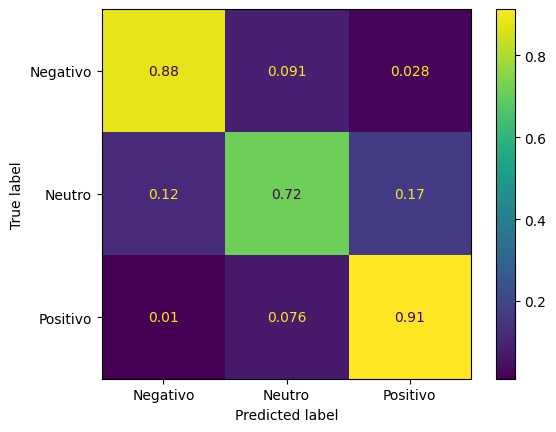

In [74]:
evaluacion_modelos(y_prueba,y_pred_lr)